In [1]:
import seaborn as sns
current_palette = sns.color_palette()
current_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
## 暂时弃用
## 方案二，使用scipy 的 curve_fit进行拟合
curve_fit_df = test_sample_df[['drug','concentration','Viability']]
group = curve_fit_df.groupby(['drug'])
concentration_list = []
drug_list = []
viability_list = []
for key, value in group:
    drug_list.append(key)
    concentration_list.append(np.array(list(sorted(set(value['concentration'])))))
    viability_tmp = []
    for key2, value2 in value.sort_values(by='concentration',ascending=True).groupby('concentration'):
        viability_tmp.append(np.array(value2['Viability']))
    viability_list.append(viability_tmp)
    #break
#print (concentration_list)

In [ ]:
## 暂时弃用，
## 方案一：使用HTS_doseresponse包
# https://medium.com/@sahmcphee/high-throughput-dose-response-data-analysis-47d27d2bf545
from HTS_doseresponse import *
hts_df = test_sample_df[['drug','concentration','Viability']]
hts_df.columns = ['sample_name','conc_nM','response']
hts_df.index = hts_df['sample_name']
hts_df = hts_df.drop(['sample_name'],axis=1)
print (hts_df.head())
hts_df = process_doseresponse_df(hts_df)
print (hts_df.head())
f = swarmplot_IC50results(hts_df)
plt.show()

In [22]:
## 数据预处理方案
#输入定义为三块板：1、样本 2、浓度 3、结果值
import pandas as pd
import numpy as np
sample_info = pd.read_csv('sample_plate.info',sep='\t',header=None)
con_info = pd.read_csv('concentration_plate.info',sep='\t',header=None)
value_info = pd.read_csv('value_plate.info',sep='\t',header=None)
sample_info = sample_info.reset_index().melt(id_vars='index', var_name='col', value_name='sample')
con_info = con_info.reset_index().melt(id_vars='index', var_name='col', value_name='concentration')
value_info = value_info.reset_index().melt(id_vars='index', var_name='col', value_name='value')

## 合并三个表格
merged_df = sample_info.merge(con_info, on=['index', 'col']).merge(value_info, on=['index', 'col'])



In [13]:
## 从数据表中提取指定的空白对照，阴性对照，阳性对照等,
blank_control_name = ['空白对照1','空白对照2']
drug1 = '紫杉醇'
drug2 = '吉非替尼'
drug1_negative_control_name = '紫杉醇阴性对照'
drug2_negative_control_name = '吉非替尼阴性对照'
drug1_positive_control_name = '紫杉醇阳性对照'
drug2_positive_control_name = '吉非替尼阳性对照'

##  计算细胞活性
blank_control_mean = merged_df[merged_df['sample'].isin(blank_control_name)][['value']].values.mean() ## 所有空白对照的均值
drug1_negative_control_mean = merged_df[merged_df['sample'].isin([drug1_negative_control_name])][['value']].values.mean()
drug2_negative_control_mean = merged_df[merged_df['sample'].isin([drug2_negative_control_name])][['value']].values.mean()

test_sample_df = merged_df[merged_df['sample'].isin([drug1,drug2])]
print (test_sample_df.head())

def cal_viability(drugname,value):
    #print (drugname,value)
    if drugname in drug1_negative_control_name:
        return (value-blank_control_mean)/(drug1_negative_control_mean-blank_control_mean)
    elif drugname in drug2_negative_control_name:
        return (value-blank_control_mean)/(drug2_negative_control_mean-blank_control_mean)
    else:
        print (drugname,drug1_negative_control_name,drug2_negative_control_name)
        return None
test_sample_df['Viability'] = test_sample_df.apply(lambda x: cal_viability(x['sample'],x['value']),axis=1)
test_sample_df.head()

    index col sample  concentration   value
12      0   2    紫杉醇           0.01  222991
13      1   2    紫杉醇           0.01  235445
14      2   2    紫杉醇           0.01  272127
15      3   2   吉非替尼           0.10  233387
16      4   2   吉非替尼           0.10  168598


/tmp/ipykernel_96916/413535731.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample_df['Viability'] = test_sample_df.apply(lambda x: cal_viability(x['sample'],x['value']),axis=1)


,index,col,sample,concentration,value,Viability
12,0,2,紫杉醇,0.01,222991,0.920981
13,1,2,紫杉醇,0.01,235445,0.977527
14,2,2,紫杉醇,0.01,272127,1.144076
15,3,2,吉非替尼,0.10,233387,1.030998
16,4,2,吉非替尼,0.10,168598,0.717749


In [15]:
### 以样本-浓度-值为键的嵌套字典结构

nested_dict = {}
for _, row in test_sample_df.iterrows():
    sample = row['sample']
    concentration = row['concentration']
    value = row['Viability']
    
    if sample not in nested_dict:
        nested_dict[sample] = {}
    if concentration not in nested_dict[sample]:
        nested_dict[sample][concentration] = []
    nested_dict[sample][concentration].append(value)
print (nested_dict)

{'紫杉醇': {0.01: [0.9209814398476868, 0.9775268315163146, 1.1440755754691496], 0.1: [1.1669089442423572, 1.1628771225142587, 1.1452560638129623], 1.0: [1.1302502408271895, 0.9314287616904291, 1.2072907262803192], 5.0: [0.8131392893006136, 0.9425979975588107, 1.0882657188455127], 10.0: [0.7650026069117593, 0.8271643988930651, 0.825139407349448], 50.0: [0.7619787406156853, 0.7289386880082817, 0.6273939887414708], 250.0: [0.2211652479366048, 0.2784961183878465, 0.2865007374268533]}, '吉非替尼': {0.1: [1.030998257012844, 0.7177488954231881, 1.058494423327502], 0.5: [0.8707014576465403, 1.1720230818881636, 1.225390882799223], 2.5: [0.897922033758994, 1.0363601786662562, 1.012432180232769], 5.0: [0.9844090080928434, 0.708412672959041, 0.894044431264822], 10.0: [1.1825486936460343, 0.8827549028061046, 0.9533011596545614], 20.0: [1.1249358366378641, 0.9984399338261187, 1.0303407084602163], 50.0: [0.9512801648383971, 1.1017379104944267, 1.0554919405982242]}}


[-2.         -1.          0.          0.69897     1.          1.69897
  2.39794001] [1.01419462 1.15834738 1.08965658 0.948001   0.8057688  0.70610381
 0.26205403]
[8.75255954e-15 1.08888513e+00 7.25078464e+01 7.54474490e-01]
IC50 value: 1.8604 µM
[-1.         -0.30103     0.39794001  0.69897     1.          1.30103
  1.69897   ] [0.93574719 1.08937181 0.98223813 0.8622887  1.00620159 1.05123883
 1.03617001]
[ 0.97249772  1.05739741 17.01236761 -2.        ]
IC50 value: 1.2308 µM


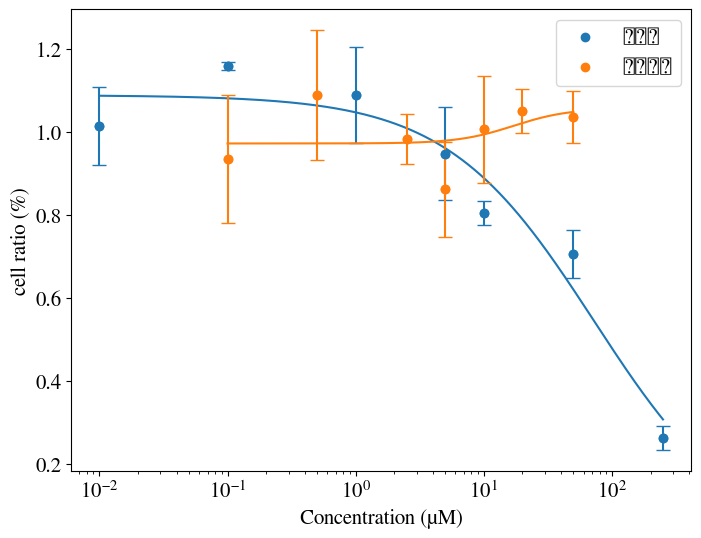

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['FreeSerif']  # 
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['font.size'] = 15

# 定义四参数 逻辑回归 模型
def four_param_logistic(x, top, bottom, ic50, slope):
    return bottom + (top - bottom) / (1 + 10**((np.log10(ic50)-x)* slope))

response_labels = [drug1,drug2]
plt.figure(figsize=(8, 6))

for i in range(0,len(response_labels)):
    drug = response_labels[i]
    concentrations = np.array(list(nested_dict[drug].keys()))
    concentrations_log = np.log10(concentrations)
    response = np.array(list(nested_dict[drug].values()))
    mean_response = np.mean(response,axis=1) # 获取响应值的均值
    std_response = np.std(response, axis=1)    # 获取响应值的标准差
    print (concentrations_log,mean_response)
# 使用 curve_fit 拟合曲线
# 初始参数：bottom=0, top=100, ic50=1, hill_slope=1
    p0 = [np.max(response), 1, np.median(concentrations_log), np.min(response)]
    bottom_init = np.min(response)
    top_init = np.max(response)
    ic50_init = np.mean(response)  # 或选择接近 50% 的点
    hill_slope_init = 1.0  # 假设为 1
    #print (bottom_init, top_init, ic50_init, hill_slope_init)
    popt = None
    pcov = None
    popt, pcov = curve_fit(four_param_logistic, concentrations_log, mean_response,bounds=([0,0,0,-2],[100,1000,100,10]))
# 提取拟合参数
    bottom, top, ic50, hill_slope = popt
    print (popt)
    print(f"IC50 value: {np.log10(ic50):.4f} µM")

# 生成拟合曲线
    x_fit = np.logspace(min(concentrations_log), max(concentrations_log), 1000)  # 生成浓度范围
    y_fit = four_param_logistic(np.log10(x_fit), bottom, top, ic50, hill_slope)

# 绘制数据点和拟合曲线
    plt.plot(x_fit, y_fit, color=current_palette[i])
    plt.errorbar(concentrations, mean_response, yerr=std_response, fmt='o', capsize=5, color=current_palette[i])
    plt.scatter(concentrations, mean_response, color=current_palette[i],label=response_labels[i])
    #break
plt.xscale('log')
plt.grid(False) ## 去除网格线
plt.xlabel('Concentration (µM)')
plt.ylabel('cell ratio (%)')
plt.title('')
plt.legend()
#plt.grid(True, which="both", ls="--")
plt.show()

### tips
# 设置 X 轴为对数刻度
#plt.xscale('log')
# 设置 X 轴范围
#plt.xlim(1, 100)  # 限制 X 轴范围为 [1, 100]
# 设置 X 轴刻度位置和标签
#plt.xticks([1, 10, 100], ['1', '10', '100']) 